In [23]:
import pandas as pd

In [24]:
csv_data = pd.read_csv('csv_data/finishedResponses.csv', low_memory=False)
actor_data = pd.read_csv('csv_data/VideoDemographics.csv', low_memory=False)

In [25]:
actor_data

,ActorID,Age,Sex,Race,Ethnicity
0,1001,51,Male,Caucasian,Not Hispanic
1,1002,21,Female,Caucasian,Not Hispanic
2,1003,21,Female,Caucasian,Not Hispanic
3,1004,42,Female,Caucasian,Not Hispanic
4,1005,29,Male,African American,Not Hispanic
...,...,...,...,...,...
86,1087,62,Male,Caucasian,Not Hispanic
87,1088,23,Male,African American,Not Hispanic
88,1089,24,Female,Caucasian,Not Hispanic
89,1090,50,Male,Asian,Not Hispanic


In [26]:
# Drop unnecessary columns from csv_data
csv_data = csv_data.drop(columns=['pos','localid','ans','queryType', 'numTries', 'clipNum', 'questNum', 'subType', 'sessionNums', 'respEmo', 'respLevel', 'dispLevel'])
# Drop first column
csv_data = csv_data.drop(columns=[csv_data.columns[0]])

In [27]:
csv_data

,ttr,clipName,dispEmo,dispVal
0,14516,1010_MTI_SAD_XX,S,50.0
1,6977,1037_IWL_HAP_XX,H,50.0
2,5760,1022_IWW_FEA_XX,F,50.0
3,10512,1067_WSI_HAP_XX,H,50.0
4,6911,1001_TIE_FEA_XX,F,50.0
...,...,...,...,...
219683,3578,1020_TIE_FEA_XX,F,50.0
219684,6235,1041_MTI_HAP_XX,H,50.0
219685,4656,1056_ITH_FEA_XX,F,50.0
219686,3875,1090_IEO_ANG_MD,A,50.0


In [28]:
# Add an Actor column based on the clipName data, the actor ID is the first four characters of the clipName
csv_data['Actor'] = csv_data['clipName'].str[:4]
# Add a phrase type column based on the clipName data, the phrase type is the characters between the first underscore and the second underscore
csv_data['PhraseType'] = csv_data['clipName'].str.split('_').str[1]
# Drop clipName column as we don't need it anymore
csv_data = csv_data.drop(columns=['clipName'])

In [29]:
# Change Actor column dtype to int64 before merging
csv_data['Actor'] = csv_data['Actor'].astype('int64')
# Merge actor_data into csv_data based on the Actor column
csv_data = pd.merge(csv_data, actor_data, left_on='Actor', right_on='ActorID')

In [30]:
csv_data

,ttr,dispEmo,dispVal,Actor,PhraseType,ActorID,Age,Sex,Race,Ethnicity
0,14516,S,50.0,1010,MTI,1010,27,Female,Caucasian,Not Hispanic
1,6977,H,50.0,1037,IWL,1037,45,Female,Caucasian,Not Hispanic
2,5760,F,50.0,1022,IWW,1022,22,Male,Caucasian,Not Hispanic
3,10512,H,50.0,1067,WSI,1067,66,Male,Caucasian,Not Hispanic
4,6911,F,50.0,1001,TIE,1001,51,Male,Caucasian,Not Hispanic
...,...,...,...,...,...,...,...,...,...,...
219683,3578,F,50.0,1020,TIE,1020,61,Female,Caucasian,Not Hispanic
219684,6235,H,50.0,1041,MTI,1041,42,Male,Caucasian,Not Hispanic
219685,4656,F,50.0,1056,ITH,1056,52,Female,African American,Not Hispanic
219686,3875,A,50.0,1090,IEO,1090,50,Male,Asian,Not Hispanic


# Cleaning

In [31]:
# Remove rows with NaN values in dispVal column
csv_data = csv_data.dropna(subset=['dispVal'])
# Remove merging on actor related columns
csv_data = csv_data.drop(columns=['ActorID', 'Actor'])
# Remove outliers in ttr column with IQR method
Q1 = csv_data['ttr'].quantile(0.25)
Q3 = csv_data['ttr'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
csv_data['ttr'] = csv_data['ttr'].clip(lower=lower_bound, upper=upper_bound)

In [32]:
features = csv_data.copy()
labels = features.pop('dispEmo')

In [33]:
features

,ttr,dispVal,PhraseType,Age,Sex,Race,Ethnicity
0,11753.5,50.0,MTI,27,Female,Caucasian,Not Hispanic
1,6977.0,50.0,IWL,45,Female,Caucasian,Not Hispanic
2,5760.0,50.0,IWW,22,Male,Caucasian,Not Hispanic
3,10512.0,50.0,WSI,66,Male,Caucasian,Not Hispanic
4,6911.0,50.0,TIE,51,Male,Caucasian,Not Hispanic
...,...,...,...,...,...,...,...
219683,3578.0,50.0,TIE,61,Female,Caucasian,Not Hispanic
219684,6235.0,50.0,MTI,42,Male,Caucasian,Not Hispanic
219685,4656.0,50.0,ITH,52,Female,African American,Not Hispanic
219686,3875.0,50.0,IEO,50,Male,Asian,Not Hispanic


In [34]:
labels

0         S
1         H
2         F
3         H
4         F
         ..
219683    F
219684    H
219685    F
219686    A
219687    H
Name: dispEmo, Length: 219148, dtype: object

# Normalization

In [35]:
import numpy as np
from tensorflow.keras import layers

In [36]:
# Replace categorical columns with ordinal values
features['PhraseType'] = features['PhraseType'].map({
    'IEO': 0,
    'TIE': 1,
    'IOM': 2,
    'IWW': 3,
    'TAI': 4,
    'MTI': 5,
    'IWL': 6,
    'ITH': 7,
    'DFA': 8,
    'ITS': 9,
    'TSI': 10,
    'WSI': 11
})

features['Sex'] = features['Sex'].map({
    'Male': 0,
    'Female': 1
})

features['Race'] = features['Race'].map({
    'Caucasian': 0,
    'African American': 1,
    'Asian': 2,
    'Unknown': 3})

features['Ethnicity'] = features['Ethnicity'].map({
    'Not Hispanic': 0,
    'Hispanic': 1
})

labels = labels.map({
    'A': 0,
    'D': 1,
    'F': 2,
    'H': 3,
    'N': 4,
    'S': 5
})

In [37]:
# Normalize ttr column with the gaussian normalization method
features['ttr'] = (features['ttr'] - features['ttr'].mean()) / features['ttr'].std()

In [38]:
features

,ttr,dispVal,PhraseType,Age,Sex,Race,Ethnicity
0,2.336836,50.0,5,27,1,0,0
1,0.628443,50.0,6,45,1,0,0
2,0.193163,50.0,3,22,0,0,0
3,1.892793,50.0,11,66,0,0,0
4,0.604837,50.0,1,51,0,0,0
...,...,...,...,...,...,...,...
219683,-0.587265,50.0,1,61,1,0,0
219684,0.363054,50.0,5,42,0,0,0
219685,-0.201701,50.0,7,52,1,1,0
219686,-0.481038,50.0,0,50,0,2,0


In [39]:
labels

0         5
1         3
2         2
3         3
4         2
         ..
219683    2
219684    3
219685    2
219686    0
219687    3
Name: dispEmo, Length: 219148, dtype: int64

In [40]:
# Splitting features and labels into training and test data
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

In [41]:
np_train_features = np.array(train_features)
normalize = layers.Normalization()
normalize.adapt(np_train_features)

# Training

In [42]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [43]:
model = tf.keras.Sequential([
    normalize,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(6, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
history = model.fit(
    np_train_features,
    train_labels,
    epochs=10
)

Epoch 1/10
5479/5479 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.1784 - loss: 1.7723
Epoch 2/10
5479/5479 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.1827 - loss: 1.7686
Epoch 3/10
5479/5479 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.1840 - loss: 1.7679
Epoch 4/10
5479/5479 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.1860 - loss: 1.7676
Epoch 5/10
5479/5479 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.1850 - loss: 1.7675
Epoch 6/10
5479/5479 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.1837 - loss: 1.7673
Epoch 7/10
5479/5479 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.1863 - loss: 1.7673
Epoch 8/10
5479/5479 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.1864 - loss: 1.7672
Epoch 9/10
5479/5479 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.1855 - loss: 1.7671
Epoch 10/10
5479/5479 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.1866 - loss: 1.7670


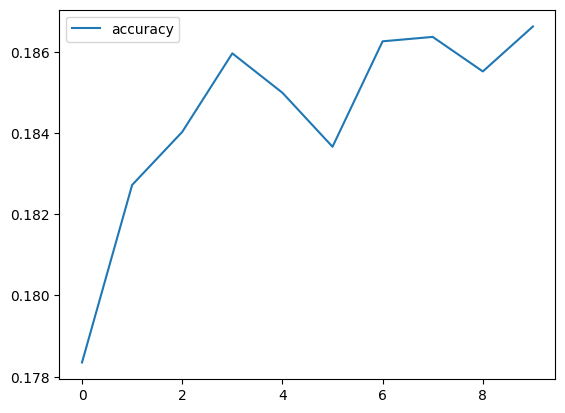

In [46]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'])
plt.legend(['accuracy'])
plt.show()

In [47]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 7)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,203 (59.39 KB)

 Trainable params: 5,062 (19.77 KB)

 Non-trainable params: 15 (64.00 B)

 Optimizer params: 10,126 (39.56 KB)

# Predictions

In [48]:
loss, m_value = model.evaluate(np.array(test_features), test_labels, verbose=2)

1370/1370 - 3s - 2ms/step - accuracy: 0.1844 - loss: 1.7676


In [49]:
predictions = model.predict(np.array(test_features))
true_labels = test_labels
# Calcul du % de bonnes prédictions
correct_predictions = np.sum(np.argmax(predictions, axis=1) == true_labels)
total_predictions = len(true_labels)
accuracy = correct_predictions / total_predictions * 100
print(f'Accuracy: {accuracy:.2f}%')


1370/1370 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Accuracy: 18.44%
